In [1]:
cd /home/tkim/Academics/DistMEC_SL/

/home/tkim/Academics/DistMEC_SL


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pdb

from classes.User import *
from classes.solver import *
from classes.Server import *
from classes.distributed_utils import *

from tqdm import tqdm, tqdm_notebook
from time import sleep
import pickle
import os
import numpy as np

In [3]:
# System Parameters
T = 2000
num_users = 9
num_svrs = 9
num_locs = 9
mu = np.random.uniform(low=0.4, high = 1, size = [num_users, num_svrs])
ceiling = 20
# w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])
space_1d_dim = 10 #4 for small, 10 for big
svr_offset_uniform = 2
max_dist = 4.5

num_explore = 1
trials = 5

# result dictionaries
result_dicts = []
performance_list = []
user_dicts = []

save_name = 'results/22_06_16_ceiling_20/'
isExist = os.path.exists(save_name)
if not isExist:
  # Create a new directory because it does not exist 
    os.makedirs(save_name)


# Generate visitng locations and server locations
usr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_locs,offset = 1.7)
svr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_svrs,offset = 1.7)

with open('traces_P_40k.pkl', 'rb') as handle:
    P_collection = pickle.load(handle)
    
with open('traces_P_40k_dict.pkl', 'rb') as handle:
    P_dict = pickle.load(handle)
    
with open('data_count_80.pkl', 'rb') as handle:
    data = np.array(pickle.load(handle))
    
# Make contextual data_mu 
data_mu = np.clip((data - 0) / (1200 - 100), 0, 1)
data_mu = data_mu[:num_users]
# data_mu = np.ones(data_mu.shape[0])

In [4]:
# Recording Mechanism
regret_centralized_dict = {}

regret_worst_dict = {}
collisions_worst_dict = {}

regret_rsv_dict = {}
collisions_rsv_dict = {}

regret_cent_stat = {}
regret_opt_stat = {}

regret_got = {}
collisions_got = {}

    
for tri in range(trials):
    svr_locs = gen_rand_locs(space_1d=space_1d_dim - svr_offset_uniform, nums=num_svrs)
    # Create Users
    Users_w = []
    for i in range(num_users):
        P_temp = P_collection
        Users_w += [User(usr_locs,svr_locs,mu[i],i,
                      max_dist = max_dist, threshold_dist = 6, self_weight = 1 - 0.85, P = P_temp, ceiling = 1,
                      sticky_mode = True, kick_mode=True, data_mu = data_mu[i])]

    GoT_Users = []
    for i in range(num_users):
        GoT_Users += [GoT_User(usr_locs, svr_locs, mu[i], i, 
                     max_dist = max_dist, threshold_dist = 6, self_weight = 1 - 0.95, P = Users_w[i].P,
                     c1 = 5000, c2 = 6000, c3 = 6000, delta = 0, rho = 0.5, epsilon = 0.1,
                     c = num_users, horizon = T, data_mu = data_mu[i])]
    
    # Create Servers
    Servers = []
    for i in range(num_svrs):
        Servers += [Server(svr_locs[i],mu,i, data_mu)]
    
    # Recorded Values - reservation
    regret_g = np.zeros(T) # Got
    collision_count_g = np.zeros(T)
    optimal_reward_g = np.zeros(T)

    regret_w = np.zeros(T) # Worst
    collision_count_w = np.zeros(T)
    optimal_reward = np.zeros(T)
    
    # Explore rounds are common/shared across all users
    explore_rounds(Users_w, num_users, Servers, mu, regret_w, collision_count_w, optimal_reward,
                   usr_move_flag = True, rounds=num_explore, data_mu = data_mu)

    round_start = ((num_svrs)*num_explore)+1

    for t in range(round_start):
        w = obtain_w(GoT_Users, len(Users_w), len(Servers))
        optimal = offline_optimal_action(w, mu, data_mu)
        play_round(GoT_Users, Servers, mu, regret_g, collision_count_g, 
                   usr_move_flag = True, debugger=False, reservation_mode = False, optimal=optimal, t = t,
                  data_mu = data_mu)

    copy_usr_loc(Users_w, GoT_Users)
    
    # Other reward recodingsexpected_reward_collision_sensing
    Users_rsv = copy.deepcopy(Users_w)
    regret_rsv = copy.deepcopy(regret_w)
    collision_count_rsv = copy.deepcopy(collision_count_w)
    for u in Users_rsv:
        u.sticky_mode = True
        u.kick_mode = True #false
        u.ceiling = ceiling
        u.expected_time_true = u.get_expected_time()

    # Centralized - true w learning
    rewards_record_ct, pulls_record_ct, ucb_ct = extract_centralized_case(Users_w, num_users, num_svrs)
    regret_ct = copy.deepcopy(regret_w)
    
    # Centralized - stationary w learning
    rewards_record_cs, pulls_record_cs, ucb_cs = extract_centralized_case(Users_w, num_users, num_svrs)
    regret_cs = copy.deepcopy(regret_w)

    # Centralized - stationary w, known mu
    w_stat = obtain_w_stationary(Users_w, num_users, num_svrs)
    optimal_stat_arms = offline_optimal_action(w_stat,mu, data_mu)[0]
    regret_cst = copy.deepcopy(regret_w)

    for (zzz,t) in zip(tqdm_notebook(range(T-round_start)),range(round_start, T)):
        w = copy.deepcopy(obtain_w(Users_w, len(Users_w), len(Servers)))
        optimal = offline_optimal_action(w, mu, data_mu)
        optimal_reward[t] = expected_reward(optimal[0], mu, w, data_mu) #optimal[1]
        
        # Distributed solution 
        play_round(Users_w, Servers, mu, regret_w, collision_count_w, 
                   usr_move_flag = True, debugger = False, reservation_mode = False, optimal =optimal, 
                   data_mu = data_mu, soft_collision = True)
        play_round(Users_rsv, Servers, mu, regret_rsv, collision_count_rsv, 
                   usr_move_flag = False, debugger = False, reservation_mode = True, optimal =optimal, t = t,
                   data_mu = data_mu, soft_collision = True)
        play_round(GoT_Users, Servers, mu, regret_g, collision_count_g, 
                   usr_move_flag = False, debugger=False, reservation_mode = False, optimal=optimal, t = t,
                   data_mu = data_mu, soft_collision = True)
        copy_usr_loc(Users_w, GoT_Users)
        copy_usr_loc(Users_w, Users_rsv)

        # Centralized Solution -  true w learning
        ucb_ct = update_ucb(rewards_record_ct, pulls_record_ct, ucb_ct, t, 1)
        arms = offline_optimal_action(w, ucb_ct, data_mu)[0]
        rewards_record_ct, pulls_record_ct = pull_super_arm(arms, mu, rewards_record_ct, pulls_record_ct)
        regret_ct[t] = optimal[1] - expected_reward(arms, mu, w, data_mu)
        
        # Centralized Solution -  stationary w learning
        ucb_cs = update_ucb(rewards_record_cs, pulls_record_cs, ucb_cs, t, 1)
        arms = offline_optimal_action(w_stat, ucb_cs)[0]
        rewards_record_cs, pulls_record_cs = pull_super_arm(arms, mu, rewards_record_cs, pulls_record_cs)
        regret_cs[t] = optimal[1] - expected_reward(arms, mu, w, data_mu)
        
        # centralized solution - stationary w, known mu
        regret_cst[t] = optimal[1] - expected_reward(optimal_stat_arms, mu, w, data_mu) 

    regret_centralized_dict[tri] = copy.deepcopy(regret_ct)

    regret_worst_dict[tri] = copy.deepcopy(regret_w)
    collisions_worst_dict[tri] = copy.deepcopy(collision_count_w)

    regret_rsv_dict[tri] = copy.deepcopy(regret_rsv)
    collisions_rsv_dict[tri] = copy.deepcopy(collision_count_rsv)

    regret_cent_stat[tri] = copy.deepcopy(regret_cs)
    regret_opt_stat[tri] = copy.deepcopy(regret_cst)

    # Alter GoT data to be algorithm accurate
    regret_g[11000:] = regret_cs[11000:]
    collision_count_g[11000:] = 0
#     collision_count_g[5000:11000] = 0.5
    
    regret_got[tri] = copy.deepcopy(regret_g)
    collisions_got[tri] = copy.deepcopy(collision_count_g)
    
#     del Users_w, Users_rsv, GoT_Users, Servers

In [5]:
save_dict = {}
save_dict['regret_centralized'] = regret_centralized_dict
save_dict['regret_worst'] = regret_worst_dict
save_dict['collisions_worst'] = collisions_worst_dict
save_dict['regret_rsv'] = regret_rsv_dict
save_dict['collisions_rsv'] = collisions_rsv_dict
save_dict['regret_cent_stat'] = regret_cent_stat
save_dict['regret_opt_stat'] = regret_opt_stat
save_dict['regret_got'] = regret_got
save_dict['collisions_got'] = collisions_got

with open("experiments/save/exp1/220726_run2_t5.pkl", "wb") as tf:
    pickle.dump(save_dict,tf)

In [6]:
with open("experiments/save/exp1/220726_run2_t5.pkl", "rb") as handle:
    load_dict = pickle.load(handle)
    
regret_centralized_dict = load_dict['regret_centralized']
regret_worst_dict = load_dict['regret_worst']
collisions_worst_dict = load_dict['collisions_worst']
regret_rsv_dict = load_dict['regret_rsv']
collisions_rsv_dict = load_dict['collisions_rsv']
regret_cent_stat = load_dict['regret_cent_stat']
regret_opt_stat = load_dict['regret_opt_stat']
regret_got = load_dict['regret_got']
collisions_got = load_dict['collisions_got'] 

# Run 2 is good
# Run 3 is done with non-random server locations
# Run 4 should be final

In [7]:
nt = len(list(collisions_got))

# calculating error bars
regret_worst_sd = np.zeros([nt,T])
regret_rsv_sd = np.zeros([nt,T])
regret_cent_stat_sd = np.zeros([nt,T])
regret_got_sd = np.zeros([nt,T])
regret_centralized_sd = np.zeros([nt,T])
regret_opt_stat_sd = np.zeros([nt,T])
collisions_worst_sd = np.zeros([nt,T])
collisions_rsv_sd = np.zeros([nt,T])
collisions_got_sd = np.zeros([nt,T])


for i in range(nt):
    regret_worst_sd[i] = np.cumsum(regret_worst_dict[i])
    regret_rsv_sd[i] = np.cumsum(regret_rsv_dict[i])
    regret_cent_stat_sd[i] = np.cumsum(regret_cent_stat[i])
    regret_got_sd[i] = np.cumsum(regret_got[i])
    
    temp_cavg = regret_centralized_dict[i]
    temp_cavg[temp_cavg<0] = 0
    regret_centralized_sd[i] = np.cumsum(temp_cavg)
    
    
    regret_opt_stat_sd[i] = np.cumsum(regret_opt_stat[i])
    collisions_worst_sd[i] = np.cumsum(collisions_worst_dict[i])
    collisions_rsv_sd[i] = np.cumsum(collisions_rsv_dict[i])
    collisions_got_sd[i] = np.cumsum(collisions_got[i])
    
regret_worst_sd2 = np.sqrt(regret_worst_sd.var(0))
regret_rsv_sd2 = np.sqrt(regret_rsv_sd.var(0))
regret_cent_stat_sd2 = np.sqrt(regret_cent_stat_sd.var(0))
regret_got_sd2 = np.sqrt(regret_got_sd.var(0))
regret_centralized_sd2 = np.sqrt(regret_centralized_sd.var(0))
regret_opt_stat_sd2 = np.sqrt(regret_opt_stat_sd.var(0))
collisions_worst_sd2 = np.sqrt(collisions_worst_sd.var(0))
collisions_rsv_sd2 = np.sqrt(collisions_rsv_sd.var(0))
collisions_got_sd2 = np.sqrt(collisions_got_sd.var(0))


# Calculating Mean
regret_worst_avg = 1/trials * regret_worst_dict[0]
regret_rsv_avg= 1/trials * regret_rsv_dict[0]
regret_cent_stat_avg= 1/trials * regret_cent_stat[0]
regret_got_avg= 1/trials * regret_got[0]

temp_cavg = regret_centralized_dict[0]
temp_cavg[temp_cavg<0] = 0
regret_centralized_avg= 1/trials * temp_cavg

regret_opt_stat_avg= 1/trials * regret_opt_stat[0]
collisions_worst_dict_avg= 1/trials * collisions_worst_dict[0]
collisions_rsv_dict_avg= 1/trials * collisions_rsv_dict[0]
collisions_got_avg= 1/trials * collisions_got[0]

for i in range(1, trials):

    regret_worst_avg += 1/trials * regret_worst_dict[i]
    regret_rsv_avg += 1/trials * regret_rsv_dict[i]
    regret_cent_stat_avg += 1/trials * regret_cent_stat[i]
    regret_got_avg += 1/trials * regret_got[i]
    
    
    temp_cavg = regret_centralized_dict[i]
    temp_cavg[temp_cavg<0] = 0
#     regret_centralized_avg= 1/trials * temp_cavg
    
    regret_centralized_avg += 1/trials * temp_cavg
    
    
    regret_opt_stat_avg += 1/trials * regret_opt_stat[i]
    collisions_worst_dict_avg += 1/trials * collisions_worst_dict[i]
    collisions_rsv_dict_avg += 1/trials * collisions_rsv_dict[i]
    collisions_got_avg += 1/trials * collisions_got[i]

In [8]:
from palettable.cubehelix import Cubehelix
palette = Cubehelix.make(start=1, rotation=-0.5, n=8)

In [9]:
palette.colors
coloridx = [0, 2, 3, 4, 5]

<Figure size 480x320 with 0 Axes>

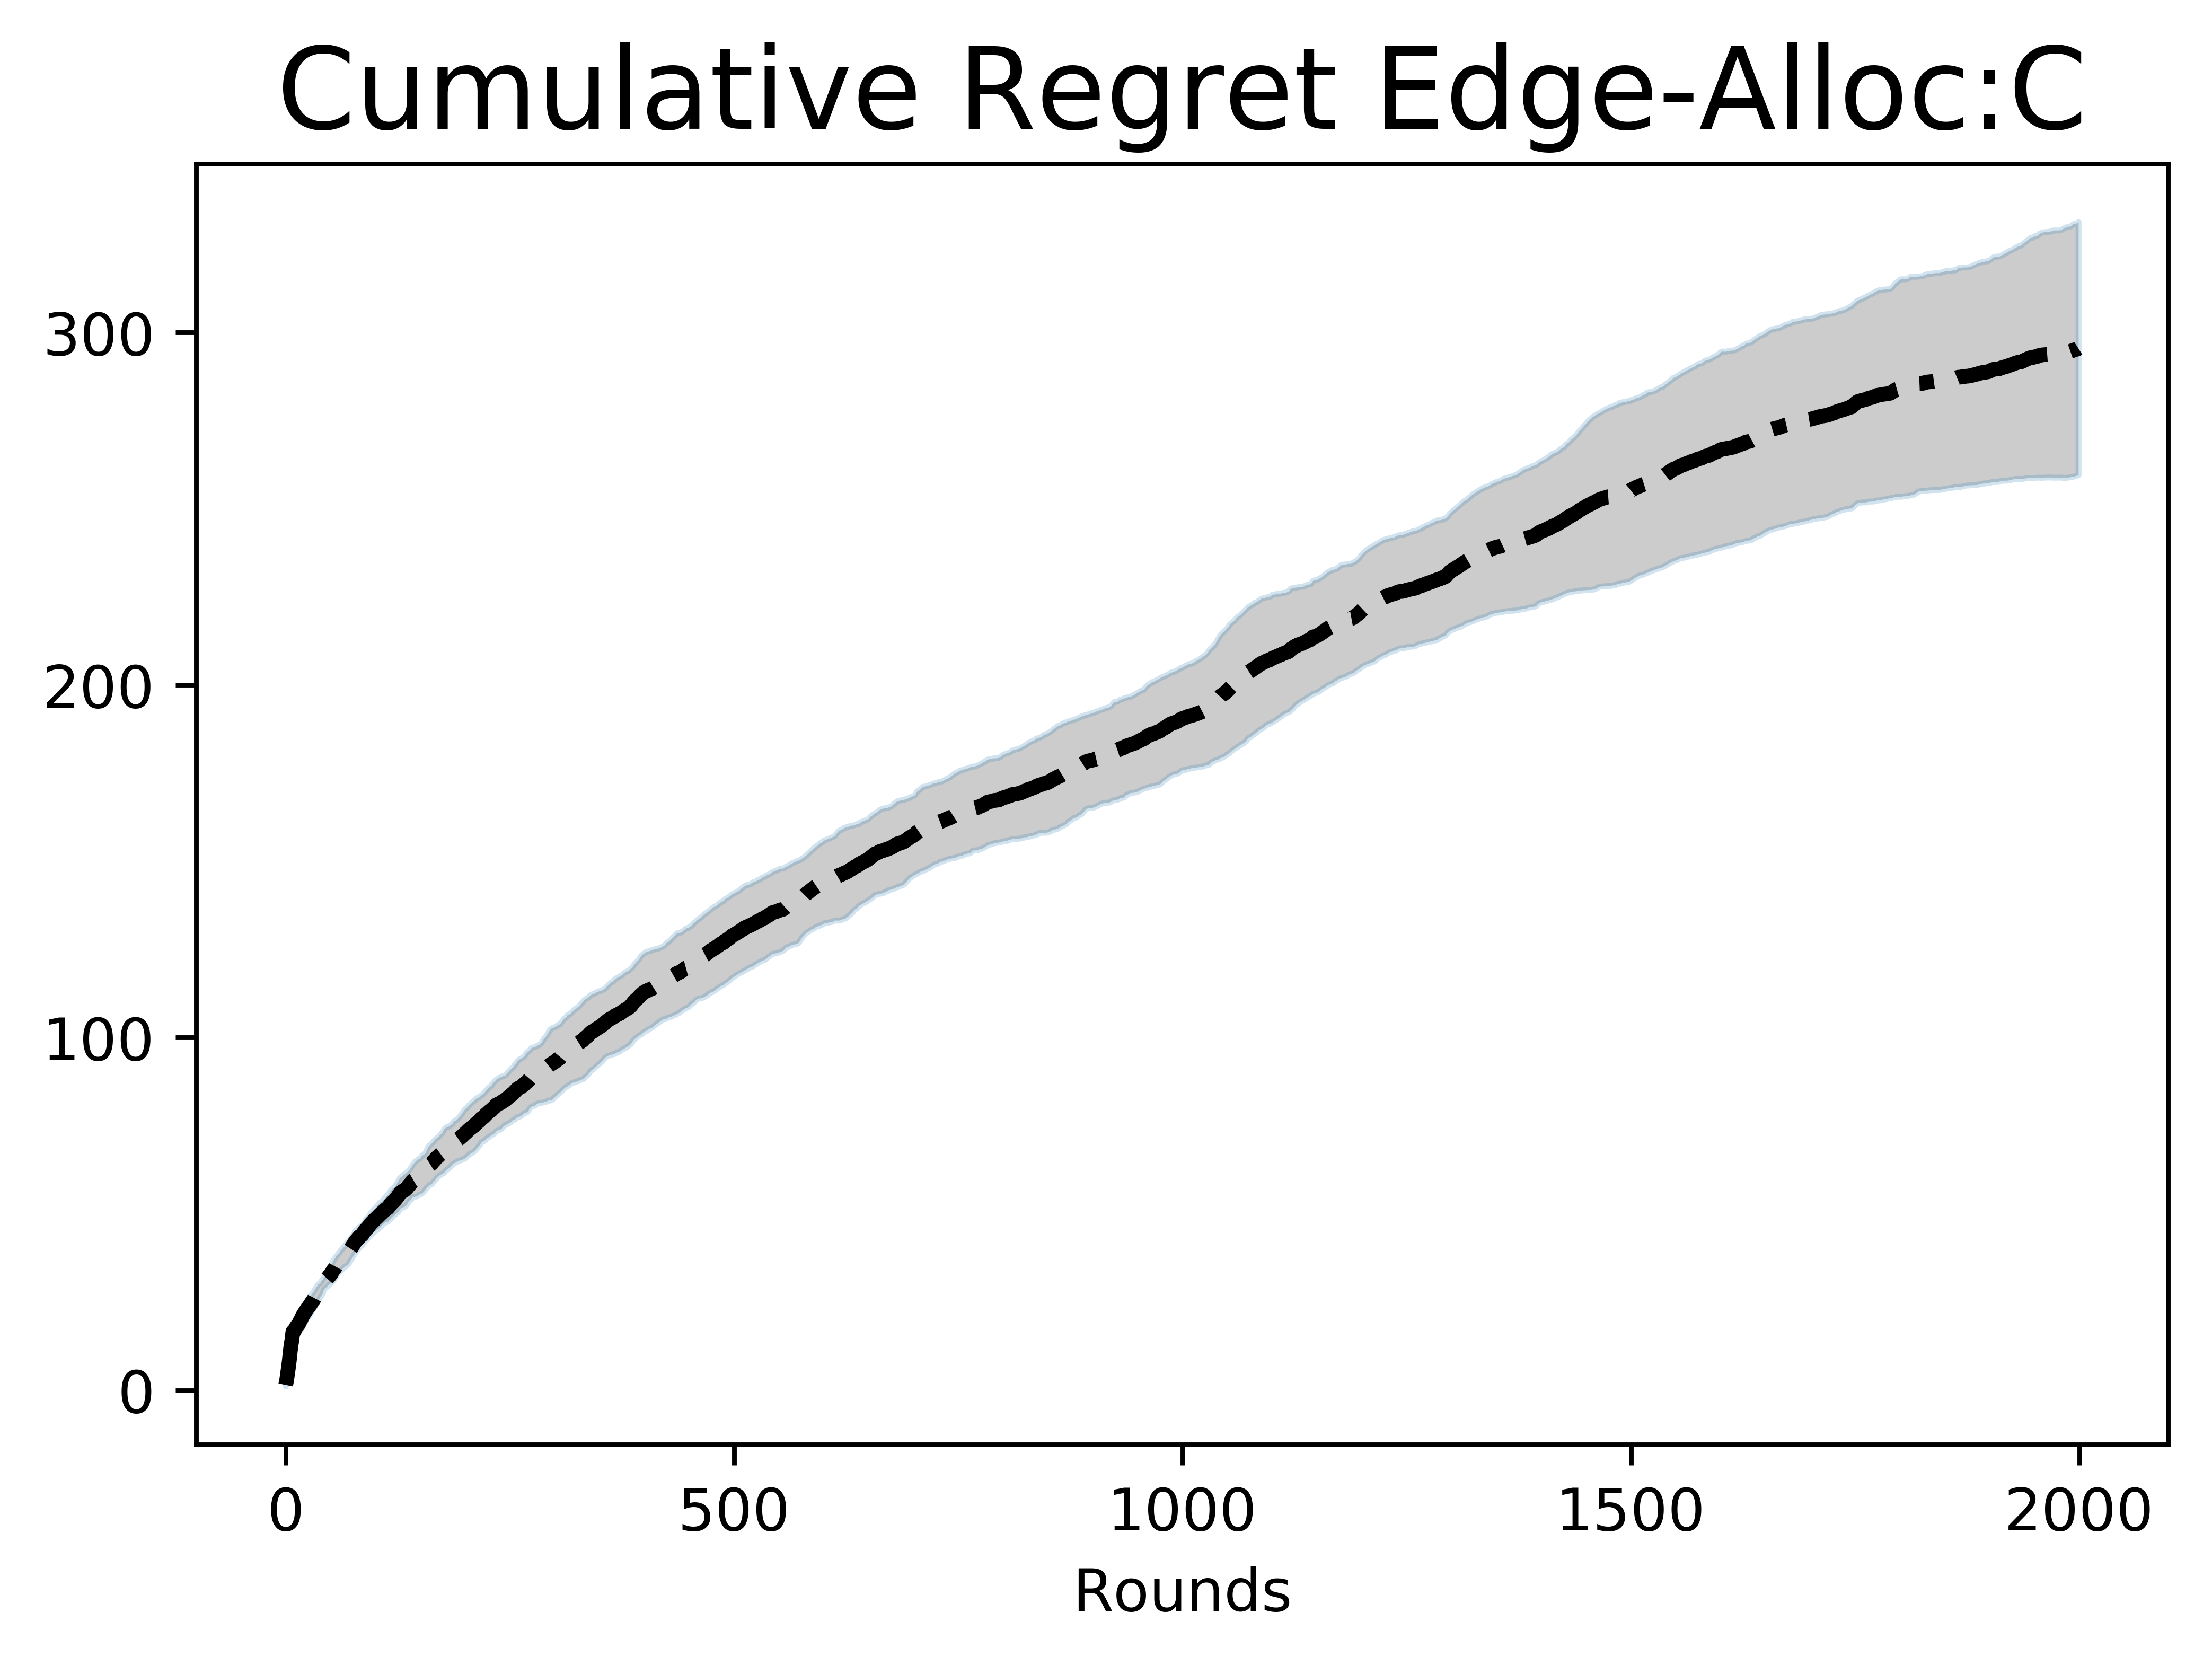

In [10]:
plt.figure(figsize=(6, 4), dpi=80)
y = np.cumsum(regret_centralized_avg)
regret_centralized_adj = regret_centralized_avg
# regret_centralized_adj[regret_centralized_adj < 0] = 0
# y_adj = np.cumsum(regret_centralized_adj)
# plt.plot(range(T), y,'-k', label = "Central Alg.", color = "tab:blue", linewidth=2.5, linestyle='dashdot')
# plt.fill_between(range(T), y-regret_centralized_sd2, y+regret_centralized_sd2,
#                 alpha=0.2, edgecolor='tab:blue', facecolor='tab:blue', linewidth=1, antialiased=True)

plt.figure(figsize=(6, 4), dpi=800)

plt.plot(range(T), y,'-k', label = "Central Alg.", color = np.divide(palette.colors[0],255), linewidth=2.5, linestyle='dashdot')
plt.fill_between(range(T), y-regret_centralized_sd2, y+regret_centralized_sd2,
                alpha=0.2, edgecolor='tab:blue', facecolor=np.divide(palette.colors[0],255), linewidth=1, antialiased=True)

#  Set Font Size Limitations
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)


plt.title('Cumulative Regret Edge-Alloc:C')
plt.xlabel('Rounds')

# plt.legend()
plt.show()

dmin 0.5008836653489817


/home/tkim/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 480x320 with 0 Axes>

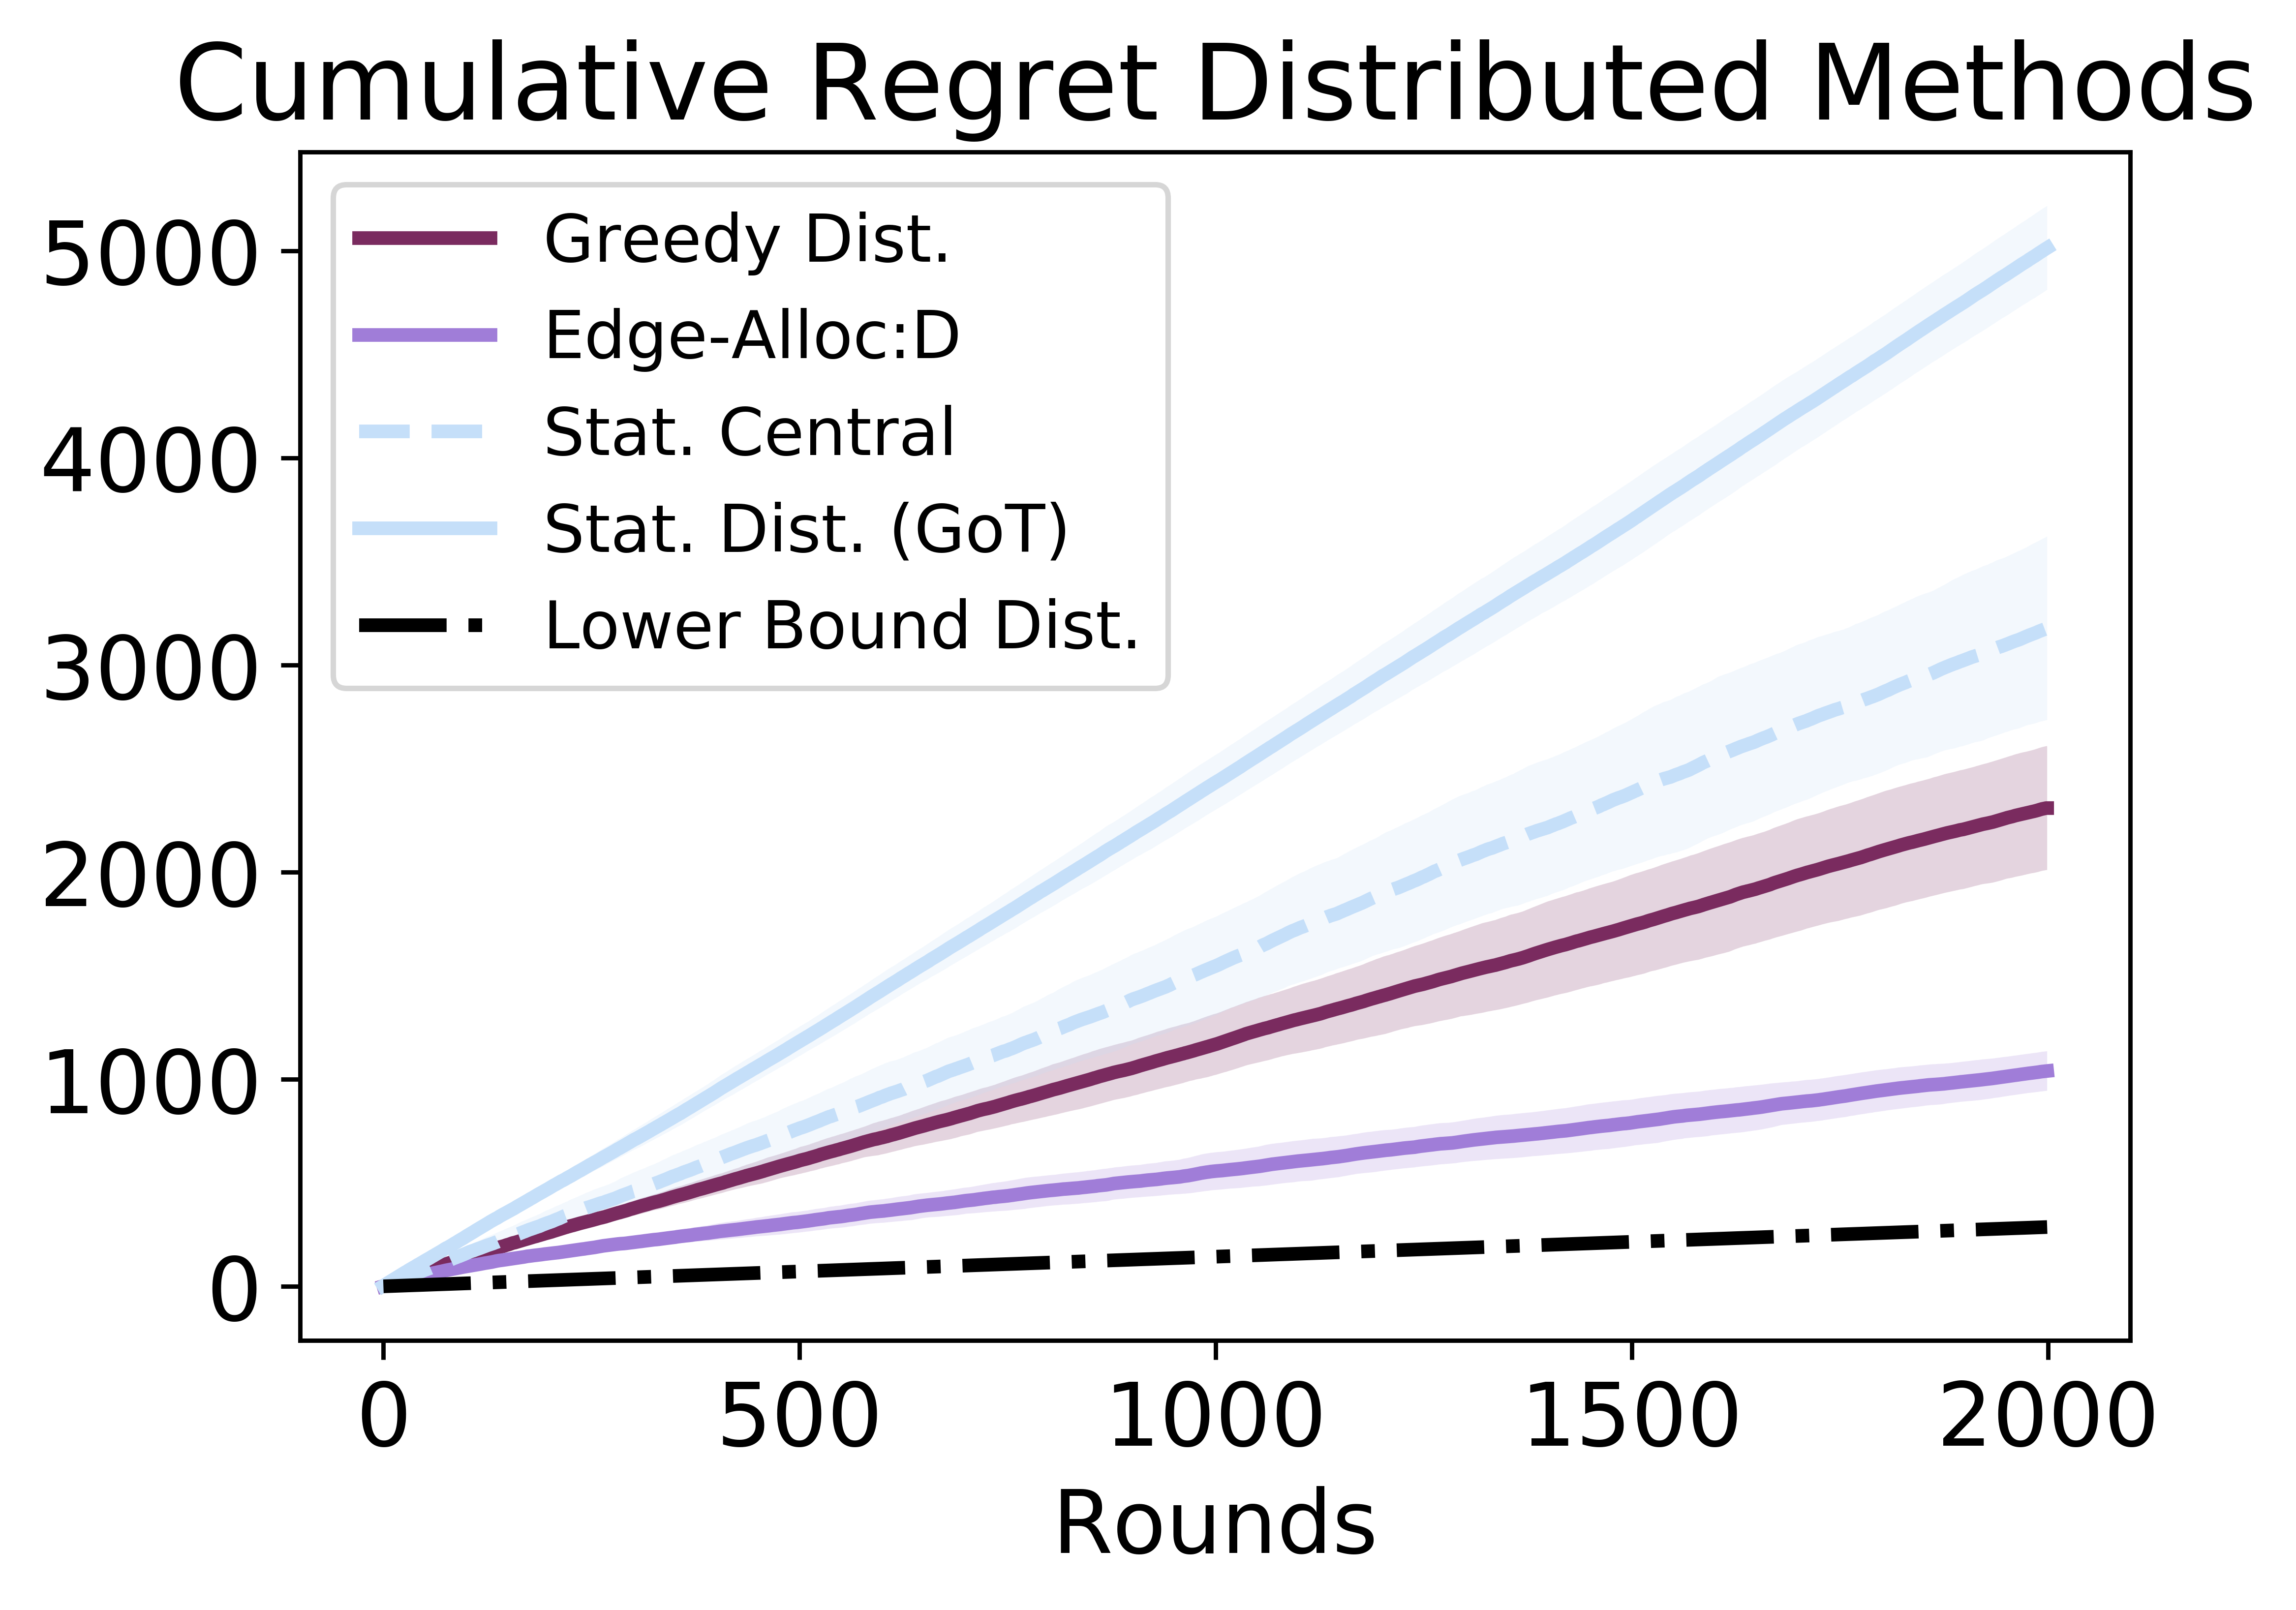

In [11]:
plt.figure(figsize=(6, 4), dpi=80)


P_temp = P_collection
User_test = User(usr_locs,svr_locs,mu[0],0,
              max_dist = max_dist, threshold_dist = 6, self_weight = 1 - 0.85, P = P_temp, ceiling = 1,
              sticky_mode = True, kick_mode=True)

a = User_test.stationary_loc

pm2 = 0.0
for i in range(a.shape[0]):
    pm2 += a[i]*(1-P_temp[i,i])
    
# Delta min calc
idx = 0
reg_threshold = 0.5
regret_temp = copy.deepcopy(regret_rsv_dict[idx])
regret_temp[regret_temp <= 0] = 30
regret_temp[regret_temp <= reg_threshold] = 10
regret_temp[collisions_rsv_dict[idx] == 0] = 10
delta_min = min(regret_temp)

print('dmin', delta_min)

# Calculate Lower Bound
pm = 0.02
po = 0.05
constant = delta_min/(po/(pm * 1) + 1)
lower_bound = np.arange(T)*constant


plt.figure(figsize=(6, 4), dpi=800)
#  Set Font Size Limitations
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)


plt.plot(np.cumsum(regret_worst_avg), label = 'Greedy Dist.', color = np.divide(palette.colors[2],255), linewidth=2.5)
y = np.cumsum(regret_worst_avg)
plt.fill_between(range(T), y-regret_worst_sd2, y+regret_worst_sd2,
                alpha=0.2, facecolor=np.divide(palette.colors[2],255), linewidth=1, antialiased=True)

plt.plot(np.cumsum(regret_rsv_avg), label = 'Edge-Alloc:D', color = np.divide(palette.colors[4],255), linewidth=2.5)
y = np.cumsum(regret_rsv_avg)
plt.fill_between(range(T), y-regret_rsv_sd2, y+regret_rsv_sd2,
                alpha=0.2, facecolor=np.divide(palette.colors[4],255), linewidth=1, antialiased=True)

plt.plot(np.cumsum(regret_cent_stat_avg), label = 'Stat. Central', color = np.divide(palette.colors[6],255), linewidth=2.5, linestyle='dashed')
y = np.cumsum(regret_cent_stat_avg)
plt.fill_between(range(T), y-regret_cent_stat_sd2, y+regret_cent_stat_sd2,
                alpha=0.2, facecolor=np.divide(palette.colors[6],255), linewidth=1, antialiased=True)

plt.plot(np.cumsum(regret_got_avg), label = 'Stat. Dist. (GoT)', color = np.divide(palette.colors[6],255), linewidth=2.5)
y = np.cumsum(regret_got_avg)
plt.fill_between(range(T), y-regret_got_sd2, y+regret_got_sd2,
                alpha=0.2, facecolor=np.divide(palette.colors[6],255), linewidth=1, antialiased=True)

plt.plot(lower_bound, label = 'Lower Bound Dist.', color = np.divide(palette.colors[0],255), linewidth=2.5, linestyle='dashdot')

# plt.plot(np.cumsum(regret_centralized_avg), label = 'central true')
# plt.plot(np.cumsum(regret_opt_stat_avg), label = 'stationary optimal')

plt.title('Cumulative Regret Distributed Methods')
plt.xlabel('Rounds')
plt.legend(prop={'size': 12})

/home/tkim/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


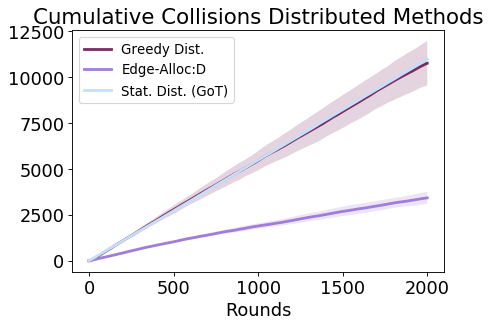

In [12]:
plt.figure(figsize=(6, 4), dpi=80)

# plt.plot(np.cumsum(collisions_worst_dict_avg), label = 'Greedy Dist.', color = "tab:green", linewidth=2.5)
# y = np.cumsum(collisions_worst_dict_avg)
# plt.fill_between(range(T), y-collisions_worst_sd2, y+collisions_worst_sd2,
#                 alpha=0.2, edgecolor='tab:green', facecolor='tab:green', linewidth=1, antialiased=True)

# plt.plot(np.cumsum(collisions_rsv_dict_avg), label = 'Edge-Alloc:D',color = "tab:red", linewidth=2.5)
# y = np.cumsum(collisions_rsv_dict_avg)
# plt.fill_between(range(T), y-collisions_rsv_sd2, y+collisions_rsv_sd2,
#                 alpha=0.2, edgecolor='tab:red', facecolor='tab:red', linewidth=1, antialiased=True)

# plt.plot(np.cumsum(collisions_got_avg), label = 'Stat. Dist. (GoT)', color = "tab:orange", linewidth=2.5)
# y = np.cumsum(collisions_got_avg)
# plt.fill_between(range(T), y-collisions_got_sd2, y+collisions_got_sd2,
#                 alpha=0.2, edgecolor='tab:orange', facecolor='tab:orange', linewidth=1, antialiased=True)

plt.plot(np.cumsum(collisions_worst_dict_avg), label = 'Greedy Dist.', color = np.divide(palette.colors[2],255), 
         linewidth=2.5)
y = np.cumsum(collisions_worst_dict_avg)
plt.fill_between(range(T), y-collisions_worst_sd2, y+collisions_worst_sd2,
                alpha=0.2, facecolor=np.divide(palette.colors[2],255), linewidth=1, antialiased=True)

plt.plot(np.cumsum(collisions_rsv_dict_avg), label = 'Edge-Alloc:D',color = np.divide(palette.colors[4],255)
         , linewidth=2.5)
y = np.cumsum(collisions_rsv_dict_avg)
plt.fill_between(range(T), y-collisions_rsv_sd2, y+collisions_rsv_sd2,
                alpha=0.2, facecolor=np.divide(palette.colors[4],255), linewidth=1, antialiased=True)

plt.plot(np.cumsum(collisions_got_avg), label = 'Stat. Dist. (GoT)', color = np.divide(palette.colors[6],255), linewidth=2.5)
y = np.cumsum(collisions_got_avg)
plt.fill_between(range(T), y-collisions_got_sd2, y+collisions_got_sd2,
                alpha=0.2, facecolor=np.divide(palette.colors[6],255), linewidth=1, antialiased=True)


matplotlib.rc('font', **font)


plt.title('Cumulative Collisions Distributed Methods')
plt.xlabel('Rounds')
plt.legend(prop={'size': 12})

/home/tkim/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


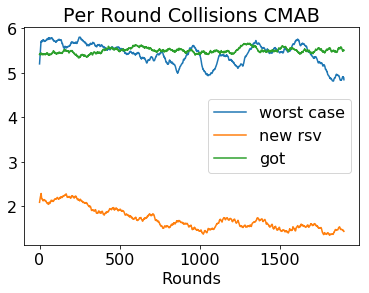

In [13]:

m = 100
plt.plot(moving_average(collisions_worst_dict_avg,m), label = 'worst case')
plt.plot(moving_average(collisions_rsv_dict_avg,m), label = 'new rsv')
plt.plot(moving_average(collisions_got_avg,m), label = 'got')


plt.title('Per Round Collisions CMAB')
plt.xlabel('Rounds')
plt.legend()



In [14]:
min(regret_centralized_dict[3])

0.0

In [15]:
max(regret_centralized_dict[3])

2.880554065494182